<a href="https://colab.research.google.com/github/ASMASHAIKH04/Bharatnatym/blob/main/Bharthnatyam_Project_5_20_postures_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bharthnatyam : 20 postures classification using Image classification

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [2]:
# STEP 1: Connect to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# STEP 2: Load the folder in the connected Google Drive
import os

# Change this path to the folder you want to analyze
folder_path = '/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET'


# Check if the folder exists
if not os.path.exists(folder_path):
    raise Exception(f"The folder {folder_path} does not exist. Please check the path.")
else:
    print("Folder Loaded Successfully")

Folder Loaded Successfully


In [4]:
import pathlib
# Define the directory path
data_dir = pathlib.Path('/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET')
# Specify the image file extensions to look for
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
# Use pathlib to find all image files in the directory and subdirectories
image_files = [f for f in data_dir.rglob('*') if f.suffix.lower() in image_extensions]
# Count the number of image files
num_images = len(image_files)
print(f"Number of images: {num_images}")

Number of images: 8209


After downloading, you should now have a copy of the dataset available. There are Thousands of total images:

Here are some Class 1 images:

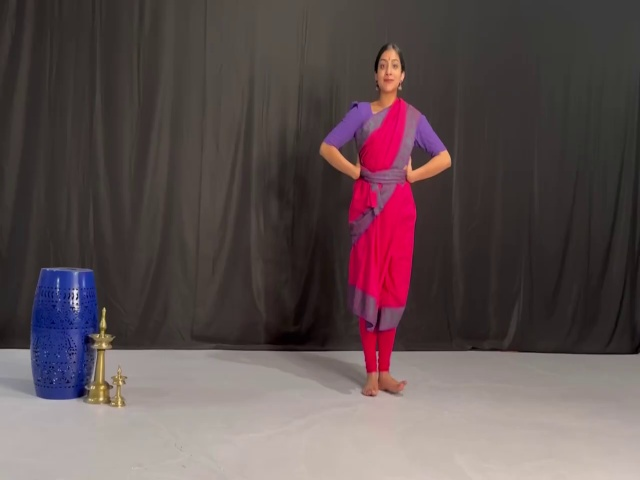

In [5]:
class1 = list(data_dir.glob('Class 1 - Thatti Mettu Adavu/*'))
PIL.Image.open(str(class1[0]))

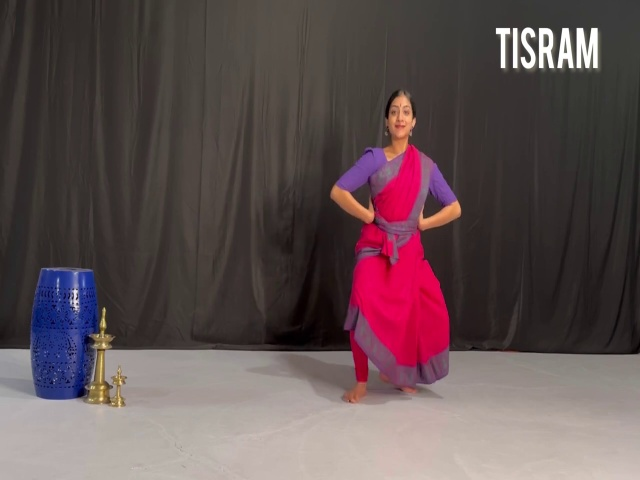

In [6]:
PIL.Image.open(str(class1[15]))

And some class 2:

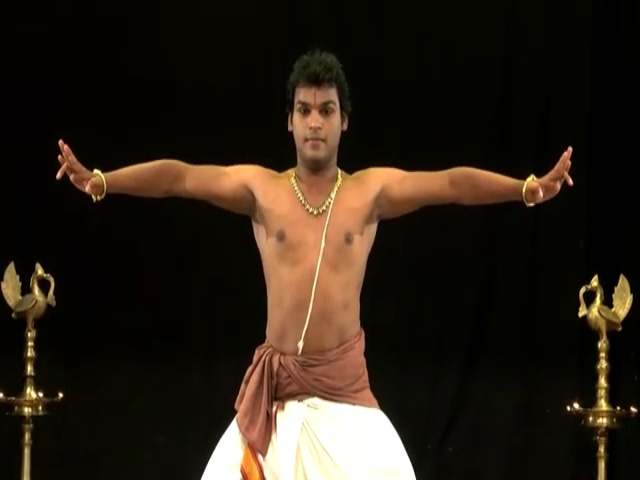

In [7]:
Class_2 = list(data_dir.glob('Class 2 - Natta Adavu 2/*'))
PIL.Image.open(str(Class_2[0]))

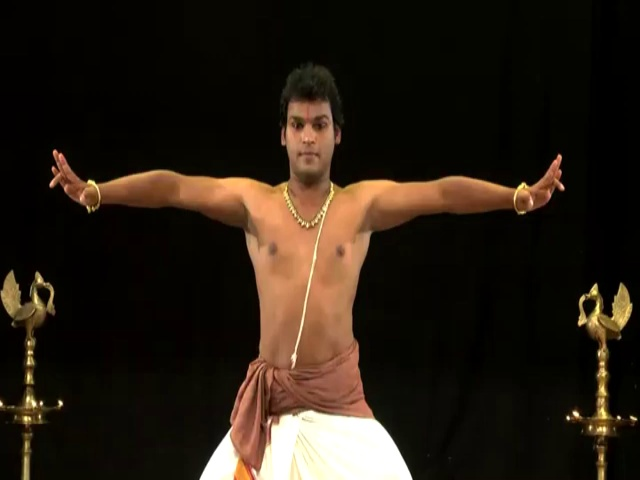

In [8]:
PIL.Image.open(str(Class_2[5]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8209 files belonging to 20 classes.
Using 6568 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8209 files belonging to 20 classes.
Using 1641 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['Class 1 - Thatti Mettu Adavu', 'Class 10 - Natta Adavu 10', 'Class 11 - Natta Adavu 11', 'Class 12 - Natta Adavu 12', 'Class 13 - Natta Adavu 13', 'Class 14 - Natta Adavu 14', 'Class 15 - Natta Adavu 15', 'Class 16 - Natta Adavu 16', 'Class 17 - Natta Adavu 17', 'Class 18 - Natta Adavu 18', 'Class 19 - Natta Adavu 19', 'Class 2 - Natta Adavu 2', 'Class 20- Natta Adavu 20', 'Class 3- Natta Adavu 3', 'Class 4- Natta Adavu 4', 'Class 5- Natta Adavu 5', 'Class 6- Natta Adavu 6', 'Class 7- Natta Adavu 7', 'Class 8- Natta Adavu 8', 'Class 9 - Natta Adavu 9']


## Visualize the data

Here are the first nine images from the training dataset:

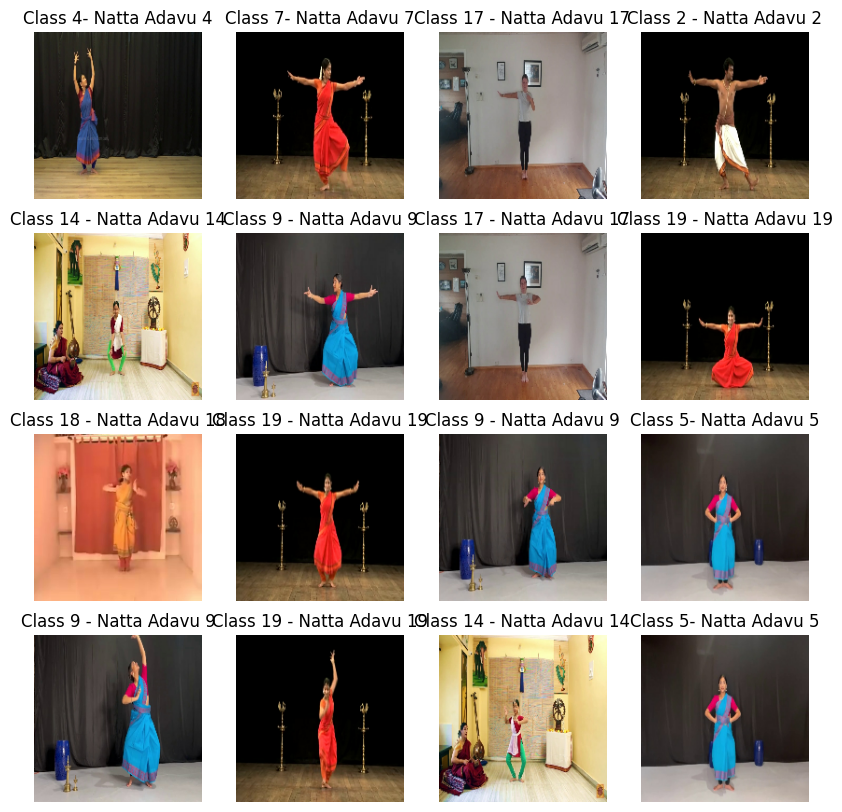

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9750908


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
206/206 [==============================] - 469s 2s/step - loss: 0.2255 - accuracy: 0.9257 - val_loss: 0.0657 - val_accuracy: 0.9665
Epoch 2/10
206/206 [==============================] - 214s 1s/step - loss: 0.0763 - accuracy: 0.9583 - val_loss: 0.0624 - val_accuracy: 0.9665
Epoch 3/10
206/206 [==============================] - 213s 1s/step - loss: 0.0675 - accuracy: 0.9598 - val_loss: 0.0672 - val_accuracy: 0.9665
Epoch 4/10
206/206 [==============================] - 214s 1s/step - loss: 0.0673 - accuracy: 0.9613 - val_loss: 0.0625 - val_accuracy: 0.9628
Epoch 5/10
206/206 [==============================] - 204s 991ms/step - loss: 0.0945 - accuracy: 0.9593 - val_loss: 0.0698 - val_accuracy: 0.9573
Epoch 6/10
206/206 [==============================] - 200s 971ms/step - loss: 0.0681 - accuracy: 0.9593 - val_loss: 0.0675 - val_accuracy: 0.9665
Epoch 7/10
206/206 [==============================] - 200s 973ms/step - loss: 0.0646 - accuracy: 0.9622 - val_loss: 0.0609 - val_accurac

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

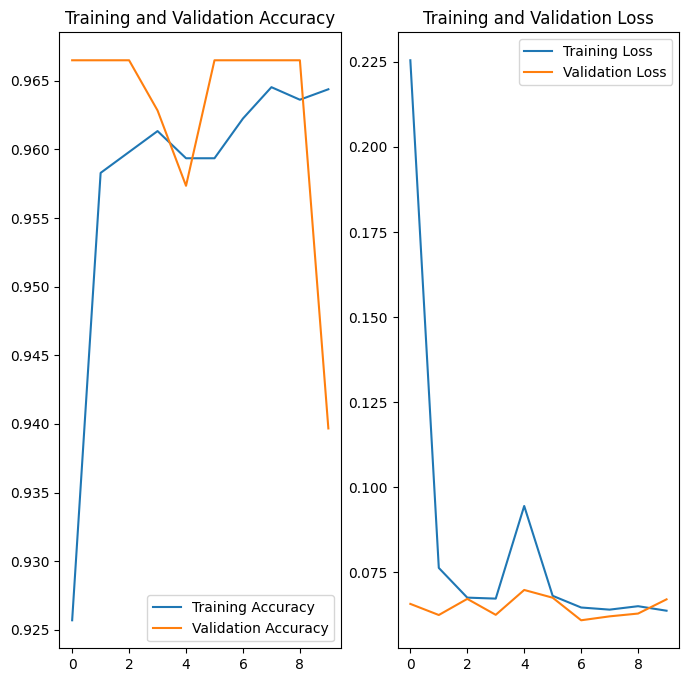

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

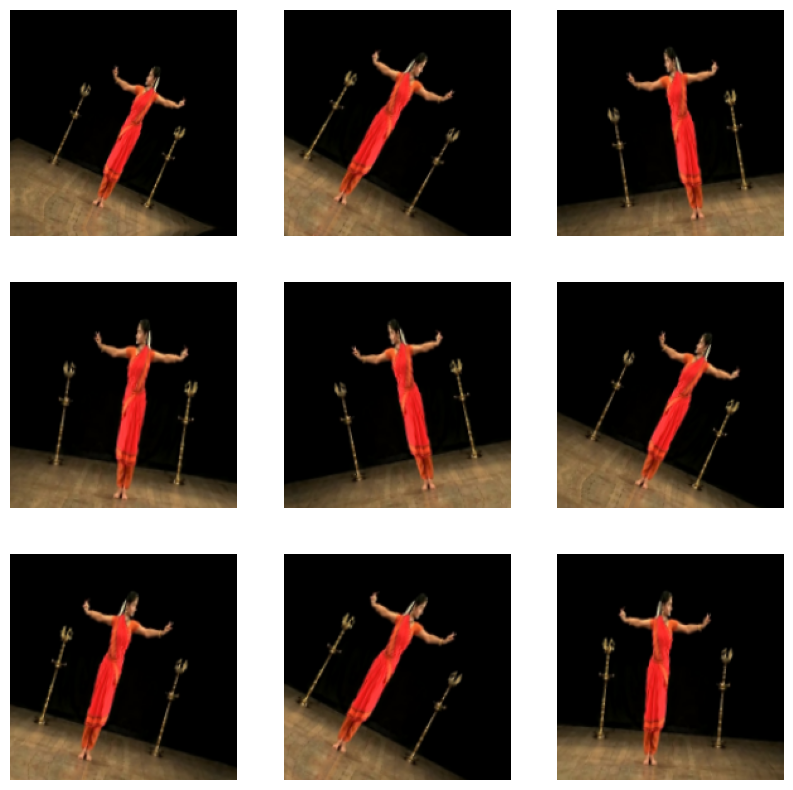

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
206/206 [==============================] - 251s 1s/step - loss: 0.4649 - accuracy: 0.8579 - val_loss: 0.1525 - val_accuracy: 0.9433
Epoch 2/15
206/206 [==============================] - 246s 1s/step - loss: 0.1369 - accuracy: 0.9414 - val_loss: 0.0786 - val_accuracy: 0.9604
Epoch 3/15
206/206 [==============================] - 243s 1s/step - loss: 0.1050 - accuracy: 0.9502 - val_loss: 0.0704 - val_accuracy: 0.9647
Epoch 4/15
206/206 [==============================] - 245s 1s/step - loss: 0.0917 - accuracy: 0.9545 - val_loss: 0.0872 - val_accuracy: 0.9506
Epoch 5/15
206/206 [==============================] - 243s 1s/step - loss: 0.0883 - accuracy: 0.9548 - val_loss: 0.0673 - val_accuracy: 0.9500
Epoch 6/15
206/206 [==============================] - 250s 1s/step - loss: 0.0876 - accuracy: 0.9540 - val_loss: 0.0661 - val_accuracy: 0.9604
Epoch 7/15
206/206 [==============================] - 243s 1s/step - loss: 0.0901 - accuracy: 0.9540 - val_loss: 0.0889 - val_accuracy: 0.9543

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

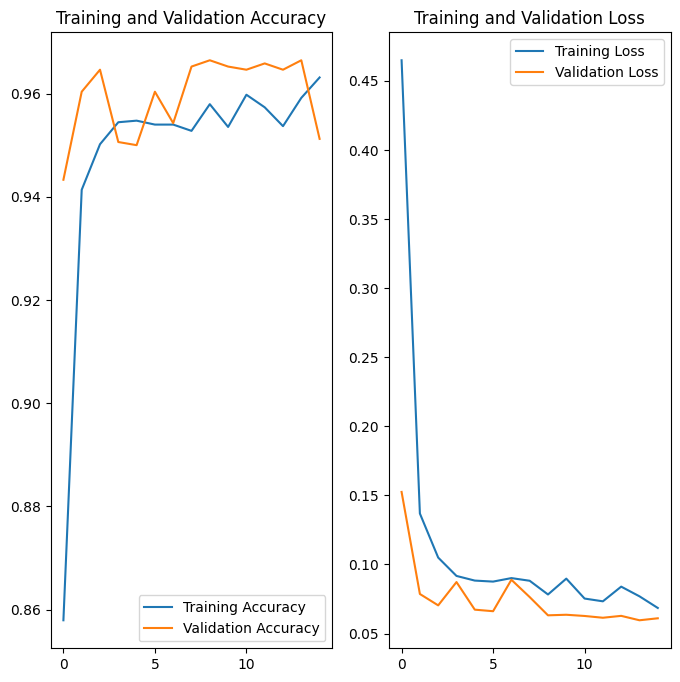

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [30]:
# Define the path to your image file directly
test_path = "/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/Class 10 - Natta Adavu 10/Class 10 - Natta Adavu 10_0005.jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Output the prediction result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 269ms/step
This image most likely belongs to Class 10 - Natta Adavu 10 with a 100.00 percent confidence.


## Predict on Test data

1/1 [==============================] - 0s 43ms/step


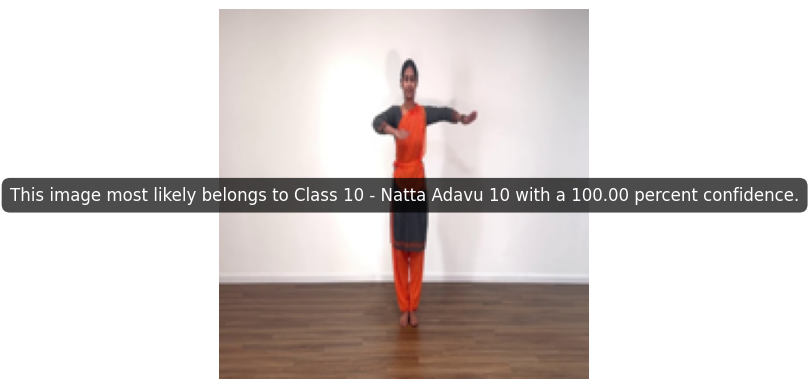

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/Class 10 - Natta Adavu 10/Class 10 - Natta Adavu 10_0005.jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [32]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [33]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [34]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [35]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [36]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [37]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to Class 10 - Natta Adavu 10 with a 100.00 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [38]:
print(np.max(np.abs(predictions - predictions_lite)))

1.680851e-05


Of the 20 classes —the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).

In [39]:
pip install mediapipe


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [40]:
import os
import csv
import cv2
import mediapipe as mp

# Define the folder path
folder_path = '/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET'

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Column names for the CSV file
columns = ['image_path', 'level'] + [f'{landmark}_{axis}' for landmark in ['nose', 'left_eye_inner', 'left_eye', 'left_eye_outer', 'right_eye_inner', 'right_eye', 'right_eye_outer', 'left_ear', 'right_ear', 'mouth_left', 'mouth_right', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky', 'left_index', 'right_index', 'left_thumb', 'right_thumb', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle', 'left_heel', 'right_heel', 'left_foot_index', 'right_foot_index'] for axis in ['x', 'y', 'z']]

# Initialize the list to hold rows of data
data = []

# Iterate over images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Add other image formats if needed
        image_path = os.path.join(folder_path, filename)

        # Read the image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image to extract pose landmarks
        result = pose.process(image_rgb)

        if result.pose_landmarks:
            landmarks = result.pose_landmarks.landmark

            # Flatten the landmarks into a row
            row = [image_path, '']  # Add skill level later if available

            for landmark in landmarks:
                row.extend([landmark.x, landmark.y, landmark.z])

            # Append the row to the data list
            data.append(row)

# Save the data to a CSV file
output_csv = '/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/pose_landmarks.csv'

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(columns)
    writer.writerows(data)

print(f'CSV file has been saved to {output_csv}')


CSV file has been saved to /content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/pose_landmarks.csv


In [41]:
import os
import csv
import cv2
import mediapipe as mp

# Folder paths
image_folder = '/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/Class 2 - Natta Adavu 2'
output_csv = '/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/Class 2 - pose_landmarks.csv'

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Function to extract pose landmarks from an image
def extract_pose_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image to extract pose landmarks
    result = pose.process(image_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        # Flatten the landmarks into a list
        landmarks_list = [image_path]
        for landmark in landmarks:
            landmarks_list.extend([landmark.x, landmark.y, landmark.z])
        return landmarks_list
    else:
        return None

# Process each image in the folder
data = []

for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Add other image formats if needed
        image_path = os.path.join(image_folder, filename)

        # Extract pose landmarks
        landmarks = extract_pose_landmarks(image_path)

        if landmarks:
            data.append(landmarks)

# Append data to the existing CSV file
with open(output_csv, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write rows of data
    for row in data:
        writer.writerow(row)

print(f'Pose landmarks extracted from images in {image_folder} and appended to {output_csv}.')


Pose landmarks extracted from images in /content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/Class 2 - Natta Adavu 2 and appended to /content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/Class 2 - pose_landmarks.csv.


In [42]:
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory containing the CSV files
csv_dir = '/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET'

# List all CSV files in the directory
csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Initialize an empty list to store DataFrames
dataframes = []

# Read each CSV file and append it to the list
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged DataFrame to a new CSV file
output_file = '/content/drive/MyDrive/bharthnatyam/new.csv'
merged_df.to_csv(output_file, index=False)

print(f"Merged CSV saved to {output_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-42-455dd26ac335>:19: DtypeWarning: Columns (0,100,200,300,400,500,600,700,800,1001,1101,1201,1301,1401,1501,1601,1701,1801,1901,2001) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Merged CSV saved to /content/drive/MyDrive/bharthnatyam/new.csv


In [43]:
import os
import csv
import cv2
import mediapipe as mp

# Folder paths
image_folder = '/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET'
output_csv = '/content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/posture_points.csv'

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Function to extract pose landmarks from an image
def extract_pose_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image to extract pose landmarks
    result = pose.process(image_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        # Flatten the landmarks into a list
        landmarks_list = [image_path]
        for landmark in landmarks:
            landmarks_list.extend([landmark.x, landmark.y, landmark.z])
        return landmarks_list
    else:
        return None

# Placeholder function for classification
def classify_pose(landmarks):
    # Example: classify based on the y-coordinate of the nose (landmark[0])
    # This is a placeholder logic, replace with your own classification logic
    nose_y = landmarks[2*0+2]  # Get the y-coordinate of the nose
    if nose_y < 0.4:
        return 'amateur'
    elif 0.4 <= nose_y < 0.6:
        return 'intermediate'
    else:
        return 'advanced'

# Process each image in the folder
data = []

for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Add other image formats if needed
        image_path = os.path.join(image_folder, filename)

        # Extract pose landmarks
        landmarks = extract_pose_landmarks(image_path)

        if landmarks:
            # Classify the pose
            classification = classify_pose(landmarks)
            # Append classification to landmarks list
            landmarks.append(classification)
            data.append(landmarks)

# Append data to the existing CSV file
with open(output_csv, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write header if file is empty
    if os.stat(output_csv).st_size == 0:
        header = ['image_path'] + [f'x{i}, y{i}, z{i}' for i in range(33)] + ['classification']
        writer.writerow(header)

    # Write rows of data
    for row in data:
        writer.writerow(row)

print(f'Pose landmarks extracted and classified from images in {image_folder} and appended to {output_csv}.')


Pose landmarks extracted and classified from images in /content/drive/MyDrive/bharthnatyam/IMAGE - DATASET and appended to /content/drive/MyDrive/bharthnatyam/IMAGE - DATASET/posture_points.csv.


In [44]:
pip install Flask opencv-python mediapipe

Saving test-4.jpg to test-4 (4).jpg
The pose of the uploaded image is classified as: intermediate


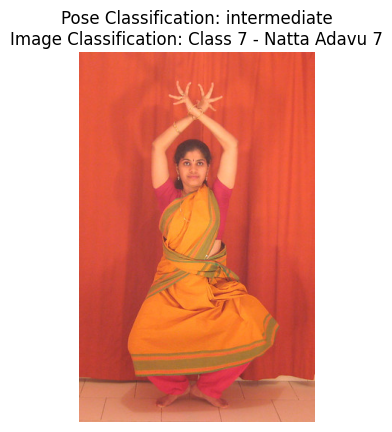

CSV file with pose landmarks and classifications saved.


In [50]:
import os
import cv2
import mediapipe as mp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import pandas as pd

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Function to extract pose landmarks from an image
def extract_pose_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image to extract pose landmarks
    result = pose.process(image_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        # Define the indices for the key landmarks
        key_indices = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25]
        landmarks_list = [image_path]
        for idx in key_indices:
            landmark = landmarks[idx]
            landmarks_list.extend([landmark.x, landmark.y, landmark.z])
        return landmarks_list
    else:
        return None

# Function to classify based on nose_y coordinate
def classify_pose(landmarks):
    nose_y = landmarks[2 * 1 + 2]  # Get the y-coordinate of the nose
    if nose_y < 0.4:
        return 'amateur'
    elif 0.4 <= nose_y < 0.6:
        return 'intermediate'
    else:
        return 'advanced'

# Load the TFLite model for image classification
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/bharthnatyam/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define your class names based on your model output
class_names = [
    "Class 1 - Thatti Mettu Adavu",
    "Class 2 - Natta Adavu 2",
    "Class 3 - Natta Adavu 3",
    "Class 4 - Natta Adavu 4",
    "Class 5 - Natta Adavu 5",
    "Class 6 - Natta Adavu 6",
    "Class 7 - Natta Adavu 7",
    "Class 8 - Natta Adavu 8",
    "Class 9 - Natta Adavu 9",
    "Class 10 - Natta Adavu 10",
    "Class 11 - Natta Adavu 11",
    "Class 12 - Natta Adavu 12",
    "Class 13 - Natta Adavu 13",
    "Class 14 - Natta Adavu 14",
    "Class 15 - Natta Adavu 15",
    "Class 16 - Natta Adavu 16",
    "Class 17 - Natta Adavu 17",
    "Class 18 - Natta Adavu 18",
    "Class 19 - Natta Adavu 19",
    "Class 20 - Natta Adavu 20",
]

# Function to preprocess the image for the TFLite model
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((180, 180))  # Resize to match model's expected sizing
    img_array = np.array(img, dtype=np.float32) / 255.0  # Convert to float32 and normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to classify an uploaded image using TFLite model
def classify_uploaded_image(image_path):
    # Preprocess the image
    input_data = preprocess_image(image_path)

    # Perform inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(output_data)
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

# Function to handle file upload, pose extraction, and classification
def upload_and_classify():
    uploaded = files.upload()
    results = []
    for filename in uploaded.keys():
        image_path = filename

        # Extract pose landmarks
        landmarks = extract_pose_landmarks(image_path)
        if landmarks:
            pose_classification = classify_pose(landmarks)
            print(f"The pose of the uploaded image is classified as: {pose_classification}")
        else:
            print("No pose landmarks detected.")
            pose_classification = 'undetected'

        # Classify image using TFLite model
        predicted_class = classify_uploaded_image(image_path)

        # Save results
        if landmarks:
            landmarks.insert(1, pose_classification)  # Insert classification after image path
            landmarks.append(predicted_class)  # Append predicted class name at the end
            results.append(landmarks)

        # Display the uploaded image and predictions
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Pose Classification: {pose_classification}\nImage Classification: {predicted_class}')
        plt.show()

    # Define the columns for the DataFrame
    columns = ['image_path', 'level'] + [f'{part}_{axis}' for part in ['nose', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee'] for axis in ['x', 'y', 'z']] + ['predicted_class']

    # Create a DataFrame and save to CSV
    df = pd.DataFrame(results, columns=columns)
    df.to_csv('/content/pose_landmarks.csv', index=False)
    print("CSV file with pose landmarks and classifications saved.")

# Call the function to upload, extract pose, and classify an image
upload_and_classify()
